# Nonlinear models for predicting `nox` using `dis` in `Boston` dataset

## Preparing the data

Information on the dataset can be [found here](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_style(style='whitegrid')

In [2]:
boston = pd.read_csv('../../datasets/Boston.csv', index_col=0)
boston = boston.reset_index(drop=True)
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
crim       506 non-null float64
zn         506 non-null float64
indus      506 non-null float64
chas       506 non-null int64
nox        506 non-null float64
rm         506 non-null float64
age        506 non-null float64
dis        506 non-null float64
rad        506 non-null int64
tax        506 non-null int64
ptratio    506 non-null float64
black      506 non-null float64
lstat      506 non-null float64
medv       506 non-null float64
dtypes: float64(11), int64(3)
memory usage: 55.4 KB


## a. Cubic regression

In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=3)
linreg = LinearRegression()

X, y = boston['dis'].values, boston['nox'].values
X, y = (X - X.mean())/X.std(), (y - y.mean())/y.std()
linreg.fit(poly.fit_transform(X.reshape(-1, 1)), y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [23]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

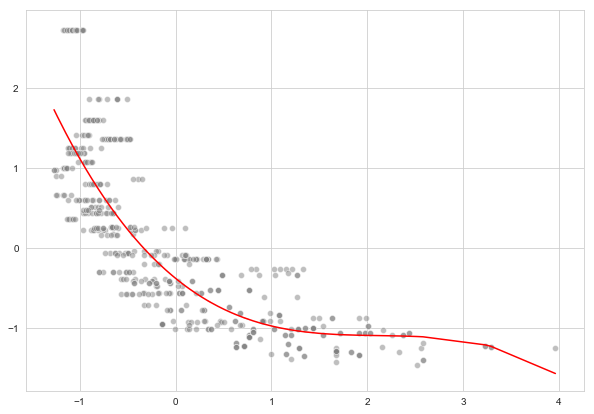

In [24]:
fig = plt.figure(figsize=(10, 7))
sns.lineplot(x=X, y=linreg.predict(poly.fit_transform(X.reshape(-1,1))), color='red')
sns.scatterplot(x=X, y=y, color='grey', alpha=0.5)

## b. Polynomial regression for degree $d = 1,\dots, 10$

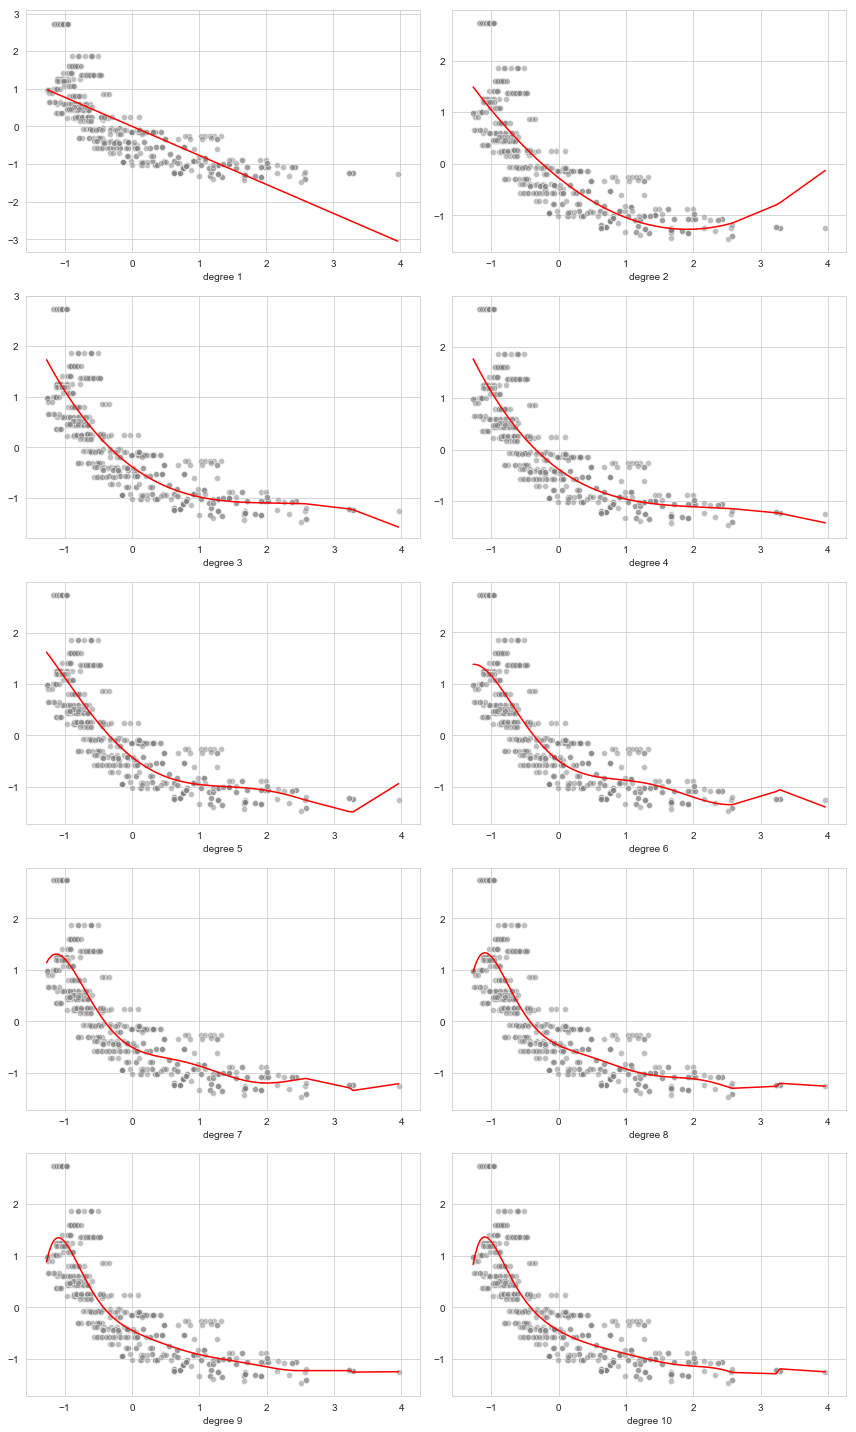

In [25]:
regs = {d:None for d in range(1, 11)}

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12,20))

for (i, d) in enumerate(regs):
    poly = PolynomialFeatures(degree=d)
    linreg = LinearRegression().fit(poly.fit_transform(X.reshape(-1, 1)), y)
    plt.subplot(5, 2, i + 1)
    sns.lineplot(x=X, y=linreg.predict(poly.fit_transform(X.reshape(-1,1))), color='red')
    sns.scatterplot(x=X, y=y, color='grey', alpha=0.5)
    plt.xlabel('degree ' + str(d))
    fig.tight_layout()

## c. Optimizing the degree of the polynomial regression model

 We'll estimate the root mean squared error using 10-fold cross validation

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

poly_reg_pipe = Pipeline([('poly', PolynomialFeatures()), ('linreg', LinearRegression())])
poly_reg_params = {'poly__degree': np.arange(1, 10)}
poly_reg_search = GridSearchCV(estimator=poly_reg_pipe, param_grid=poly_reg_params, cv=10,
                               scoring='neg_mean_squared_error')
poly_reg_search.fit(X.reshape(-1, 1), y)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linreg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'poly__degree': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [15]:
poly_reg_search.best_params_

{'poly__degree': 3}

In [16]:
np.sqrt(-poly_reg_search.best_score_)

0.5609950540561572

## d.  Cubic spline regression with $4$ degrees of freedom

For this we'll use [`patsy`](https://patsy.readthedocs.io/en/latest/) Python module. This [blog post](https://www.analyticsvidhya.com/blog/2018/03/introduction-regression-splines-python-codes/) was helpful. 

We're using [`patsy.bs`](https://patsy.readthedocs.io/en/latest/API-reference.html#spline-regression) default choice for the knots (equally spaced quantiles), and default degree (3).

In [19]:
from patsy import dmatrix

X_tr = dmatrix("bs(x, df=4)", {'x': X})
spline_reg = LinearRegression()
spline_reg.fit(X_tr, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

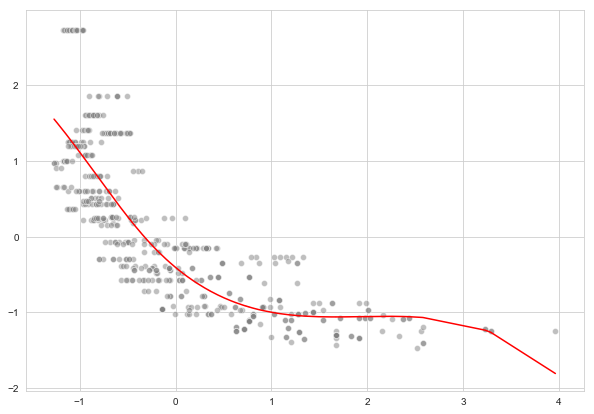

In [20]:
fig = plt.figure(figsize=(10, 7))
sns.lineplot(x=X, y=spline_reg.predict(X_tr), color='red')
sns.scatterplot(x=X, y=y, color='grey', alpha=0.5)

In [28]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(spline_reg.predict(X_tr), y))

0.5324989652537614

## e. Cubic spline regression with degrees of freedom $d = 4, \dots 11$

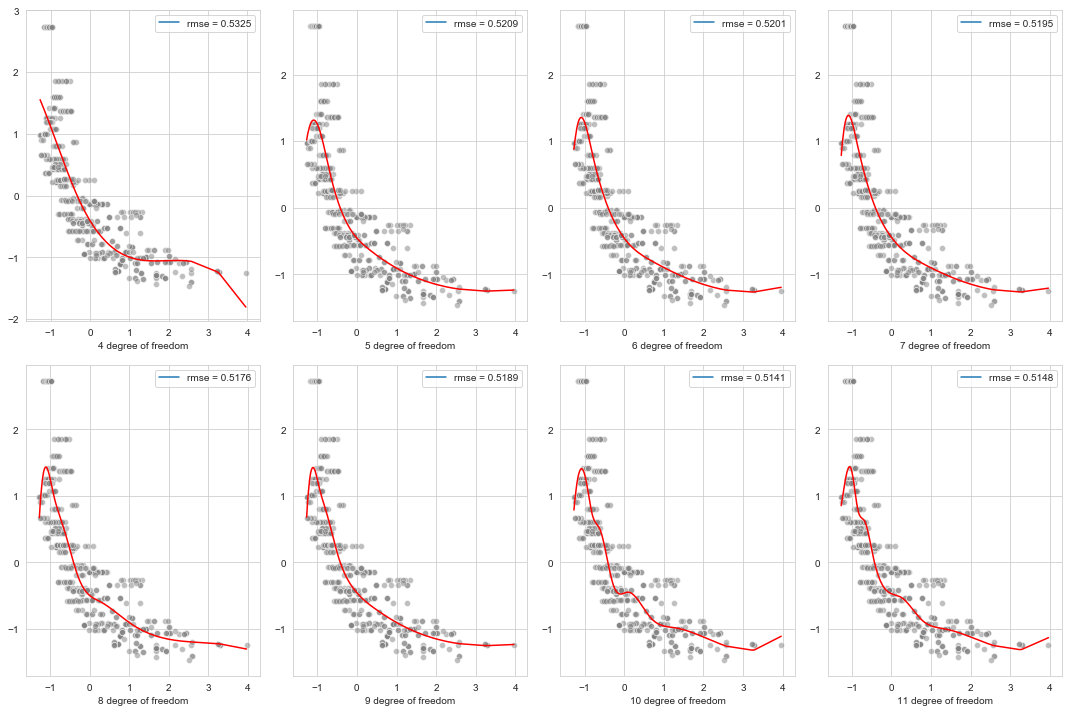

In [51]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))

for (i, d) in enumerate(range(4, 12)):
    
    X_tr = dmatrix("bs(x, df=" + str(d) + ")", {'x': X})
    spline_reg = LinearRegression()
    spline_reg.fit(X_tr, y)
    rmse = round(np.sqrt(mean_squared_error(spline_reg.predict(X_tr), y)), 4)
    
    plt.subplot(2, 4, i + 1)
    sns.lineplot(x=X, y=spline_reg.predict(X_tr), color='red')
    plt.plot([], [], label='rmse = ' + str(rmse))
    sns.scatterplot(x=X, y=y, color='grey', alpha=0.5)
    plt.xlabel(str(d) + ' degree of freedom')
    fig.tight_layout()

## f. Optimizing the degrees of freedom of the cubic spline model

In [70]:
from sklearn.model_selection import cross_val_score

spline_cv_rmses = {d:None for d in range(4, 12)}

for d in spline_cv_rmses:
    X_tr = dmatrix("bs(x, df=" + str(d) + ")", {'x': X})
    linreg = LinearRegression()
    cv_rmse = np.sqrt(-np.mean(cross_val_score(linreg, 
                                               X_tr, y, cv=10, 
                                               scoring='neg_mean_squared_error')))
    spline_cv_rmses[d] = cv_rmse

spline_cvs = pd.DataFrame({'dofs': list(spline_cv_rmses.keys()), 
                           'cv_rmses': list(spline_cv_rmses.values())})
spline_cvs

,dofs,cv_rmses
0,4,0.632125
1,5,0.589646
2,6,0.592387
3,7,0.608314
4,8,0.629096
5,9,0.621942
6,10,0.640462
7,11,0.661658


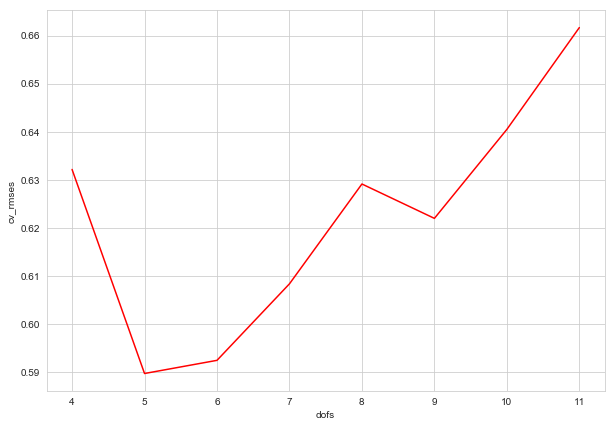

In [84]:
fig = plt.figure(figsize=(10, 7))
sns.lineplot(x=spline_cvs['dofs'], y = spline_cvs['cv_rmses'], color='red')

By cross-validation, (for this choice of knots), 5 is the best number of degrees of freedom